In [1]:
import os
import cv2
from tqdm import tqdm
import numpy as np

REBUILD_DATA = False

In [2]:
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS : 1}
    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in os.listdir(label):
                try:
                    path = os.path.join(label, f)
                    print(path)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))

                    if img is None:
                        continue
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    print('Error',e)
                    pass
                
        np.random.shuffle(self.training_data)
        images = np.array([item[0] for item in self.training_data], dtype=np.float32)
        labels = np.array([item[1] for item in self.training_data], dtype=np.int32)
        
        # Save images and labels separately
        np.save('images.npy', images)
        np.save('labels.npy', labels)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [3]:
training_data = np.load('images.npy')
training_labels = np.load('labels.npy')

print(len(training_data))
print(training_data.shape)

24946
(24946, 50, 50)


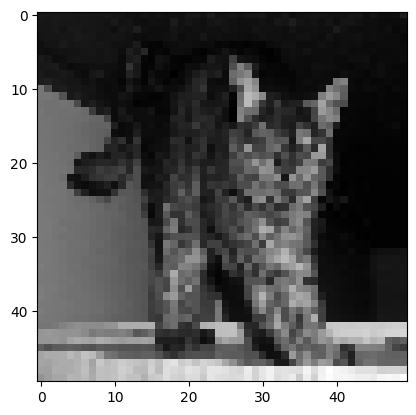

In [4]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1200], cmap="gray")
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
 
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            print(self._to_linear)
            ## Expected value is 2 * 2 * 128
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1)
    
net = Net()


512


In [16]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i for i in training_data]).view(-1, 50, 50)
X = X/255.0

y = torch.Tensor([i for i in training_labels])

val_percent = 0.1
val_size = int(len(X) * val_percent)
print(val_size)

2494


In [20]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [17]:
BATCH_SIZE = 100 ## Change the batch size if we get memory errors

EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        # print(i, i + BATCH_SIZE)
        batch_X = train_X[i: i + BATCH_SIZE].view(-1, 1,50, 50)
        batch_y = train_y[i: i + BATCH_SIZE]

        net.zero_grad()
        outputs = net(batch_X)

        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

print(loss)



100%|██████████| 225/225 [00:38<00:00,  5.91it/s]

tensor(0.2284, grad_fn=<MseLossBackward0>)


In [18]:
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print('Accuracy: ', round(correct/total, 3))

100%|██████████| 2494/2494 [00:04<00:00, 549.05it/s]

Accuracy:  0.621


In [14]:
def fwd_pass(X, y, train = False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs,y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

In [21]:
def test(size = 32):

    random_start = np.random.randint(len(test_X))
    X, y = test_X[random_start: random_start + size], test_y[random_start: random_start + size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50), y)
    return val_acc, val_loss

val_acc, val_loss = test(size = 1000)
print(val_acc, val_loss)


0.624 tensor(0.2308, grad_fn=<MseLossBackward0>)


In [22]:
import time

MODEL_NAME = f"model: {int(time.time())}"

net = Net()

print(MODEL_NAME)

def train():
    BATCH_SIZE = 32
    EPOCHS = 5
    with open('model.log', 'w') as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i: i + BATCH_SIZE].view(-1, 1, 50, 50)
                batch_y = train_y[i: i + BATCH_SIZE]

                acc, loss = fwd_pass(batch_X, batch_y, train= True)
                if i % 50 == 0:
                    with torch.no_grad():
                        val_acc, val_loss = test(size = 50)
                    f.write(f'{MODEL_NAME}, {round(time.time(),3)}, {round(float(acc), 2)}, {round(float(loss),4)}, {val_acc}, {val_loss}\n')

512
model: 1719897643


In [23]:
train()

100%|██████████| 702/702 [00:45<00:00, 15.58it/s]


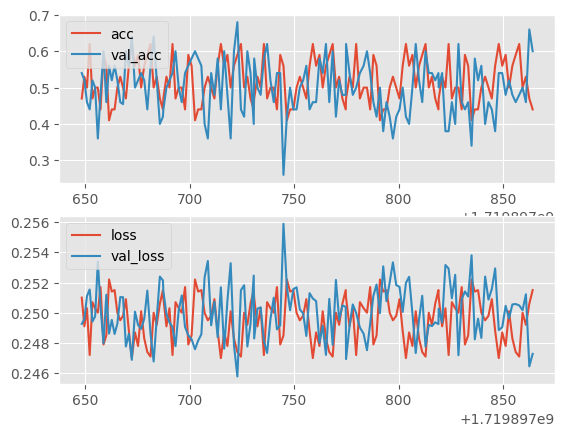

In [25]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

def create_acc_loss_graph(model_name):
    try:
        contents = open('model.log', 'r').read().split('\n')

        times = []
        accuracies = []
        losses = []

        val_accs = []
        val_losses = []

        for c in contents:
            if model_name in c:
                _, timestamp, acc, loss, val_acc, val_loss = c.split(', ')

                times.append(float(timestamp))
                accuracies.append(float(acc))
                losses.append(float(loss))

                val_accs.append(float(val_acc))
                val_losses.append(float(val_loss))

        fig = plt.figure()

        ax1 = plt.subplot2grid((2, 1), (0, 0))
        ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

        ax1.plot(times, accuracies, label='acc')
        ax1.plot(times, val_accs, label='val_acc')
        ax1.legend(loc=2)

        ax2.plot(times, losses, label='loss')
        ax2.plot(times, val_losses, label='val_loss')
        ax2.legend(loc=2)

        plt.show()

    except Exception as e:
        print(f"Error occurred: {str(e)}")

create_acc_loss_graph(MODEL_NAME)
